In [31]:
%run ../robustness_analysis.ipynb

## Define the environment

In [4]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

In [5]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the initial states
x0_bounds = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

In [6]:
def env_builder(delta):
    return MutatedCartPoleEnv(masscart=delta[0], force_mag=delta[1]), x0_bounds

## Define the agent

In [7]:
from stable_baselines3 import DQN

model = DQN.load("best_dqn")

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.predict(obs, deterministic=True)[0],
    # some agents (like PID) needs to be reset for each run
    'model_reset': None
}

## Define the STL property

In [8]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def signal_builder(record, time_index):
    return {
        "pos": stl.Signal(
            normalize(np.abs(record[:, 0]), pos_range),
            time_index
        ),
        "angle": stl.Signal(
            normalize(np.abs(record[:, 2]), angle_range),
            time_index
        )
    }

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

## Define distance metric

In [9]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

## Start analysis

In [10]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')
if not os.path.exists('data'):
    os.mkdir('data')

In [32]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['falsification_num_trials'] = 1
analysis.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 10,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 1,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 200}

In [10]:
delta, delta_dist = analysis.any_unsafe_deviation()


================ Any unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=746972, Mon Oct 24 09:29:12 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 4.599659939306144e-02 1.0e+00 1.53e-01  1e-01  2e-01 0:49.3


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


    2     12 -2.500000099341070e-01 1.2e+00 2.22e-01  3e-01  3e-01 1:37.5
termination on ftarget=0.0 (Mon Oct 24 09:30:58 2022)
final/bestever f-value = -2.500000e-01 -2.500000e-01
incumbent solution: [0.6912899207707376, 0.23175143395629388]
std deviation: [0.261269056533148, 0.25538044988400327]


In [11]:
print(delta, delta_dist)

[1.52143362 3.72355592] 0.4294654691318442


STL robustness value: -0.250000009934107
Initial state: [-0.03776176 -0.02614852 -0.01011591  0.00239574]


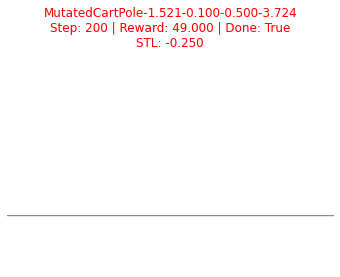

In [12]:
analysis.visualize_deviation(delta, "gifs/any_counterexample.gif")

In [13]:
delta, delta_dist = analysis.min_unsafe_deviation()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=711995, Mon Oct 24 09:31:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.270054625666072e-02 1.0e+00 2.06e-01  2e-01  2e-01 0:38.5
    2     12 1.002346161425960e-01 1.2e+00 1.99e-01  2e-01  2e-01 1:17.4
    3     18 4.650233907610403e-01 1.3e+00 1.64e-01  1e-01  2e-01 1:55.4
    4     24 5.477461534677417e-01 1.4e+00 1.44e-01  1e-01  1e-01 2:33.5
    5     30 4.012810943863879e-01 1.3e+00 1.54e-01  1e-01  1e-01 3:11.7
    6     36 -7.881184547033530e-01 1.7e+00 1.80e-01  1e-01  2e-01 3:49.4
    7     42 -6.209456766942536e-01 1.4e+00 3.15e-01  2e-01  3e-01 4:16.4
    8     48 -7.441183394261488e-01 1.3e+00 2.54e-01  2e-01  2e-01 4:44.7
    9     54 -7.165121673118684e-01 1.1e+00 2.71e-01  2e-01  2e-01 5:17.4
   10     60 -5.699480130662826e-01 1.3e+00 2.62e-01  2e-01  2e-01 5:47.3
   11     66 -6.369029120562864e-01 1.3e

In [14]:
print(delta, delta_dist)

[1.39781737 6.92486302] 0.26463968654697395


STL robustness value: -0.0580440233181202
Initial state: [-0.04935644 -0.04983654 -0.03418737 -0.0372845 ]


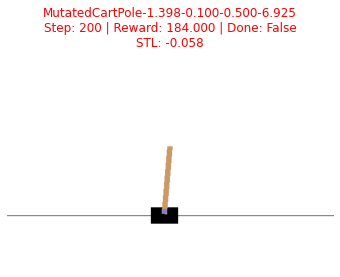

In [15]:
analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

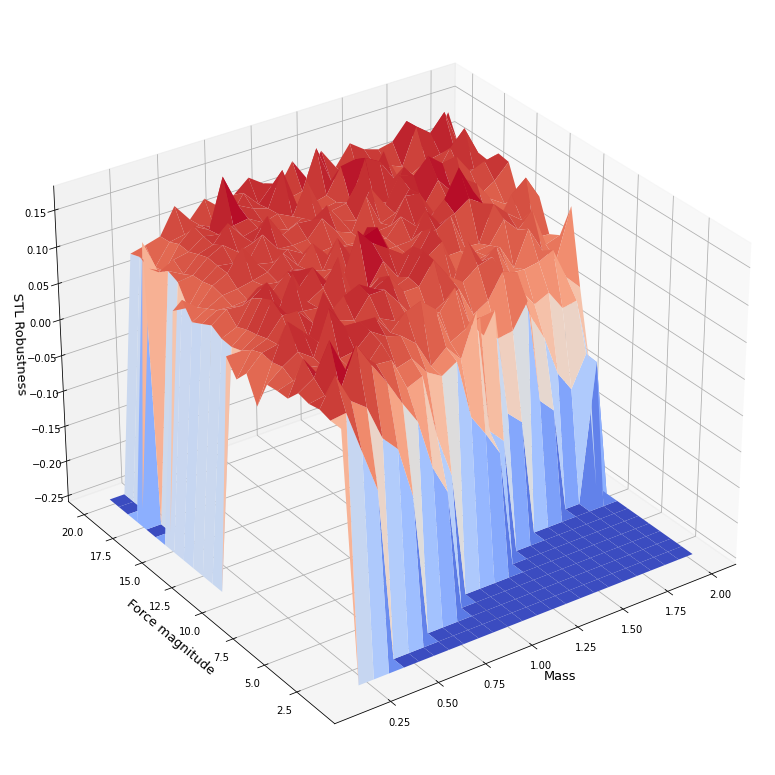

In [12]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="masses", y_name="forces",
                                                   z_name='STL Robustness')
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png')
plt.show()

## Compute robustness boundary

In [17]:
analysis.robustness_boundary()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=787486, Mon Oct 24 10:59:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.092444618605247e-02 1.0e+00 1.92e-01  2e-01  2e-01 0:32.0
    2     12 1.716641261903181e-01 1.1e+00 1.55e-01  1e-01  1e-01 1:08.4
    3     18 2.671578128063064e-01 1.3e+00 1.13e-01  8e-02  9e-02 1:47.2
    4     24 8.272659818987025e-01 1.2e+00 1.30e-01  1e-01  1e-01 2:29.1
    5     30 5.071448318975815e-01 1.6e+00 1.09e-01  8e-02  8e-02 3:14.5
    6     36 4.631014414340898e-01 2.0e+00 1.04e-01  7e-02  8e-02 3:56.8
    7     42 2.503050016270798e-01 1.9e+00 8.64e-02  5e-02  6e-02 4:38.9
    8     48 8.419435315076050e-02 2.2e+00 6.77e-02  3e-02  4e-02 5:21.5
    9     54 1.946674484393402e-01 1.8e+00 6.98e-02  3e-02  4e-02 6:04.0
   10     60 1.703332508395889e-01 1.8e+00 5.64e-02  2e-02  3e-02 6:46.1
   11     66 1.769578466411542e-01 1.5e+00 4.

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 9.151604224369688e-03 1.0e+00 1.56e-01  1e-01  1e-01 0:31.8
    2     12 4.246508910308657e-03 1.2e+00 2.27e-01  2e-01  2e-01 1:05.4
    3     18 6.219458504455564e-03 1.1e+00 2.04e-01  2e-01  2e-01 1:30.5
    4     24 5.997214636881860e-03 1.2e+00 1.83e-01  1e-01  2e-01 1:59.4
    5     30 3.719002167108535e-03 1.2e+00 1.96e-01  1e-01  2e-01 2:32.7
    6     36 4.532333124044158e-03 1.5e+00 1.43e-01  8e-02  1e-01 3:06.2
    7     42 4.953461938818365e-03 1.7e+00 1.58e-01  9e-02  2e-01 3:39.6
    8     48 9.786892721447610e-04 2.1e+00 1.78e-01  1e-01  2e-01 4:12.9
    9     54 1.038749129934702e-03 2.0e+00 1.55e-01  9e-02  1e-01 4:43.0
   10     60 1.572144879345440e-04 2.0e+00 1.58e-01  9e-02  1e-01 5:16.5
   11     66 1.732882855652704e-03 2.6e+00 1.41e-01  8e-02  1e-01 5:49.5
   12     72 7.626003820577984e-05 2.7e+00 1.16e-01  5e-02  8e-02 6:21.5
   13     78 5.250370714028235e-04 2.3e+00 1.15e-01 

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.052380402372549e-03 1.0e+00 1.88e-01  2e-01  2e-01 0:32.5
    2     12 3.199133616109448e-03 1.3e+00 1.76e-01  1e-01  2e-01 1:01.7
    3     18 3.461826414674960e-03 1.2e+00 1.41e-01  1e-01  1e-01 1:34.6
    4     24 4.097547198802907e-04 1.3e+00 1.27e-01  9e-02  9e-02 2:05.9
    5     30 6.993605894636049e-03 1.3e+00 1.11e-01  6e-02  8e-02 2:38.6
    6     36 9.973398228254676e-04 1.3e+00 8.62e-02  4e-02  6e-02 3:11.4
    7     42 7.170960001119317e-04 1.4e+00 6.12e-02  3e-02  3e-02 3:43.7
    8     48 6.625977499390218e-04 1.3e+00 5.90e-02  2e-02  3e-02 4:16.4
    9     54 9.016937934491819e-04 1.5e+00 5.15e-02  2e-02  3e-02 4:49.1
   10     60 2.442864868244979e-04 1.7e+00 4.16e-02  1e-02  2e-02 5:21.6
   11     66 6.998874955249159e-04 1.9e+00 3.71e-02  1e-02  2e-02 5:54.2
   12     72 7.480595598654336e-04 2.0e+00 2.94e-02  6e-03  1e-02 6:26.9
   13     78 7.188466861721590e-04 2.3e+00 3.28e-02 

0.22315302576403917

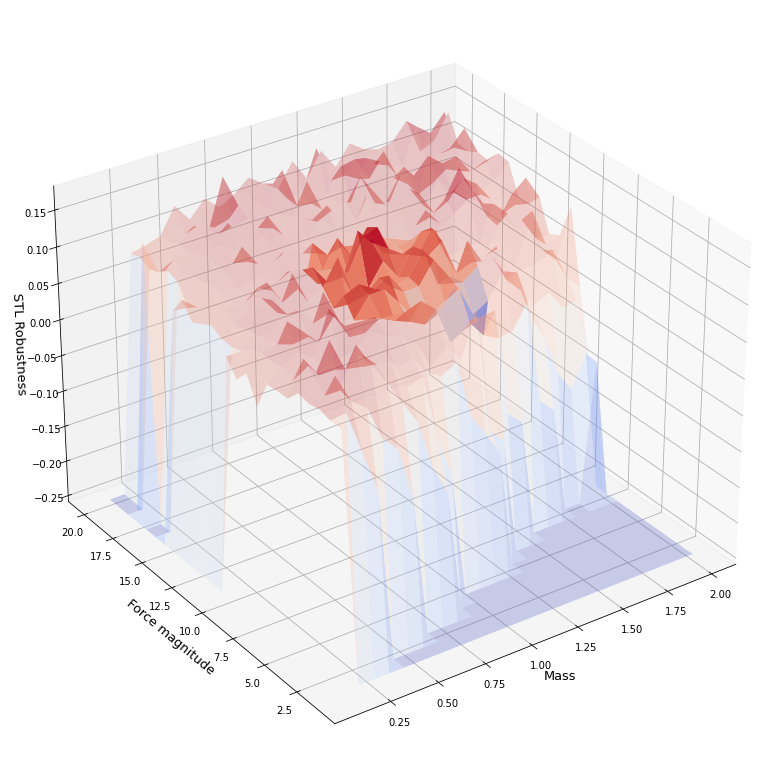

In [51]:
boundary = 0.223153
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="masses", y_name="forces",
                                                   z_name='STL Robustness', boundary=boundary)

# center = normalize(delta_0, dev_bounds)
# X = np.linspace(center[0] - boundary, center[0] + boundary)
# Y1 = center[1] + np.sqrt(np.clip(boundary**2 - (X - center[0])**2, 0, None))
# Y2 = center[1] - np.sqrt(np.clip(boundary**2 - (X - center[0])**2, 0, None))
# ax.plot(scale(X, dev_bounds[0]), scale(Y1, dev_bounds[1]), 0.08, zorder=10, color='black')
# ax.plot(scale(X, dev_bounds[0]), scale(Y2, dev_bounds[1]), 0.08, zorder=10, color='black')

ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-boundary.png')
plt.show()

## Use reward as the property evaluation function

In [18]:
def episode_eval_reward(obs_record, reward_record):
    return reward_record.sum() - 200

In [19]:
analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
analysis_reward.options['falsification_num_trials'] = 1

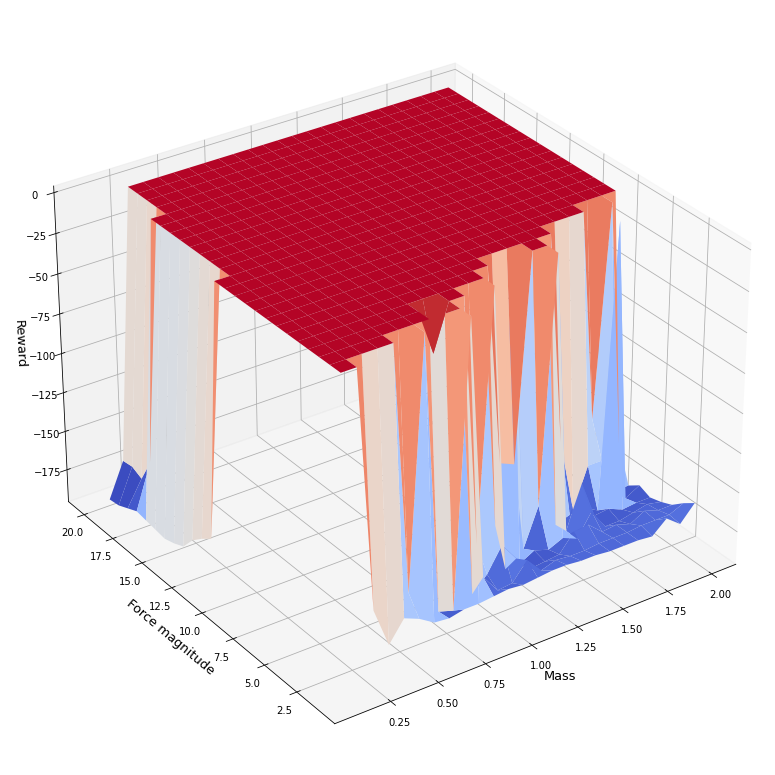

In [20]:
ax, masses, forces, grid_data = analysis_reward.grid_plot(masscart, force_mag, 25, 25, out_dir="data_reward",
                                                          x_name="masses", y_name="forces", z_name='Reward')
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-reward.png')
plt.show()